<a href="https://colab.research.google.com/github/Anku5hk/The_ML_Workflow/blob/master/Pytorch/ResNet_ConcreteCrack_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -P /content/ https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip 

--2020-05-12 08:20:26--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245259777 (234M) [application/zip]
Saving to: ‘/content/concrete_crack_images_for_classification.zip’

concrete_crack_imag 100%[===================>] 233.90M  19.7MB/s    in 13s     

2020-05-12 08:20:40 (18.0 MB/s) - ‘/content/concrete_crack_images_for_classification.zip’ saved [245259777/245259777]



In [0]:
!unzip -q  /content/concrete_crack_images_for_classification.zip -d  /content/data/

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch.utils.data import  DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset
import numpy as np

In [2]:
print(torch.cuda.get_device_name(0)) 

Tesla K80


In [0]:
def show_data(data_sample, shape = (28, 28)):
    plt.imshow(data_sample[0].numpy().reshape(shape), cmap='gray')
    plt.title('y = ' + data_sample[1])

In [0]:
# !ls /content/data/Negative | wc -l

In [0]:
# !ls /content/data/Positive | wc -l

In [0]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True, show_data = False):
        directory="/content/data"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()

        number_of_samples = 40000

        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        self.show_data = show_data
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:

            self.Y=self.Y[0:30000]
            self.all_files = self.all_files[0:30000]
            self.len=len(self.all_files)

        else:

            self.Y=self.Y[30000:]
            self.all_files = self.all_files[30000:]
            self.len=len(self.all_files)
    

    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        image=Image.open(self.all_files[idx])
        if self.show_data:
          image = np.asarray(Image.open(self.all_files[idx]))

        y=self.Y[idx]
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

In [0]:
''''
dataset = Dataset(train=False)
print(len(dataset.Y))
for sample in [16 ,103]:
    plt.imshow(dataset[sample][0])
    plt.xlabel("y="+str(dataset[sample][1].item()))
    plt.title("training data, sample {}".format(int(sample)))
    plt.show()
'''

'\'\ndataset = Dataset(train=False)\nprint(len(dataset.Y))\nfor sample in [16 ,103]:\n    plt.imshow(dataset[sample][0])\n    plt.xlabel("y="+str(dataset[sample][1].item()))\n    plt.title("training data, sample {}".format(int(sample)))\n    plt.show()\n'

In [0]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# transforms.ToTensor()
#transforms.Normalize(mean, std)
#transforms.Compose([])

transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean, std)])

dataset_train = Dataset(transform=transform,train=True)
dataset_val = Dataset(transform=transform,train=False)

In [6]:
len(dataset_train), len(dataset_val)

(30000, 10000)

In [7]:
dataset_train[0][0].shape

torch.Size([3, 227, 227])

In [8]:
size_of_image=3*227*227
size_of_image

154587

In [9]:
model = models.resnet18(pretrained=True).cuda(0)
model.requires_grad_(False) # set parameters to non trainable
model.fc = torch.nn.Linear(in_features=512, out_features=2).cuda(0)
model.fc.requires_grad_(True)

Linear(in_features=512, out_features=2, bias=True)

In [0]:
BS = 1500

train_loader = DataLoader(dataset_train, batch_size = BS)
valid_loader = DataLoader(dataset_val, batch_size= BS)

In [0]:
LR = 0.1

cost_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)

TRAIN_STEP = len(train_loader)/BS
VALID_STEP = len(valid_loader)/BS

EPOCHS = 15 

In [12]:
# training

TRAIN_LOSS = []
VAL_LOSS = []
VAL_ACC = []

for epoch in range(EPOCHS):
  running_loss = 0.0

  for (x, y) in train_loader:
    model.train()
    optimizer.zero_grad()
    x, y = x.cuda(0), y.cuda(0)
    z = model(x)
    loss = cost_function(z, y)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()

  train_l = running_loss/TRAIN_STEP
  TRAIN_LOSS.append(train_l)
  total = 0
  correct = 0 
  print("Epoch", epoch+1)
  print("Training loss:", train_l) 
  running_loss = 0.0

  for (x,y) in valid_loader:
    model.eval()
    x, y = x.cuda(0), y.cuda(0)
    z = model(x)
    loss = cost_function(z, y)
    scheduler1.step(loss)
    scheduler2.step()
    running_loss+=loss.item()
    _, yhat = torch.max(z,1)
    total += y.size(0)
    correct += (yhat == y).sum().item()

  valid_l = running_loss/VALID_STEP
  valid_a = 100 * correct / total
  print("Valid loss:", valid_l) 
  VAL_LOSS.append(valid_l)
  torch.cuda.empty_cache()
  print('VAL_Accuracy: %d %%' % valid_a)
  VAL_ACC.append(valid_a)

Epoch 1
Training loss: 1144.7818133980036
Valid loss: 228.69105903165678
VAL_Accuracy: 97 %
Epoch 2
Training loss: 159.0913281776011
Valid loss: 103.98422234824724
VAL_Accuracy: 99 %
Epoch 3
Training loss: 87.72867587395012
Valid loss: 89.86828276621443
VAL_Accuracy: 99 %
Epoch 4
Training loss: 81.98633920401335
Valid loss: 90.21908098033495
VAL_Accuracy: 99 %
Epoch 5
Training loss: 81.97493464685977
Valid loss: 90.2708512065666
VAL_Accuracy: 99 %
Epoch 6
Training loss: 81.9747350178659
Valid loss: 90.27666066374097
VAL_Accuracy: 99 %
Epoch 7
Training loss: 81.97473445907235
Valid loss: 90.27730607028518
VAL_Accuracy: 99 %
Epoch 8
Training loss: 81.97473445907235
Valid loss: 90.27768724731035
VAL_Accuracy: 99 %
Epoch 9
Training loss: 81.97473445907235
Valid loss: 90.27762578002043
VAL_Accuracy: 99 %
Epoch 10
Training loss: 81.97473445907235
Valid loss: 90.27748248939002
VAL_Accuracy: 99 %
Epoch 11
Training loss: 81.97473445907235
Valid loss: 90.2775986386197
VAL_Accuracy: 99 %
Epoch 12

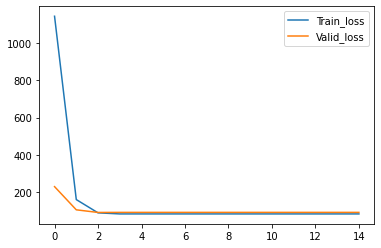

In [15]:
# draw graph for train and valid loss

a = np.arange(0,EPOCHS)
plt.plot(a, TRAIN_LOSS, label="Train_loss")
plt.plot(a, VAL_LOSS, label="Valid_loss")
plt.legend()
plt.show()

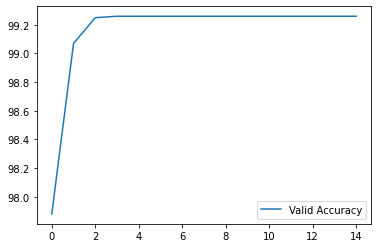

In [16]:
plt.plot(a, VAL_ACC, label="Valid Accuracy")
plt.legend()
plt.show()

In [0]:
# !rm -rf /content/data/

In [0]:
# save model state(parameters)

PATH =  "/content/contrete-crack-weights"
torch.save(model.state_dict(), PATH)

In [17]:
PATH =  "/content/contrete-crack-weights"
loaded_model = models.resnet18(pretrained=False).cuda(0)
loaded_model.fc = torch.nn.Linear(in_features=512, out_features=2).cuda(0)
loaded_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
sample_data = Dataset(train=False, show_data=True)
sample_loader = DataLoader(sample_data, batch_size= BS) 

In [0]:
# plot test results

loaded_model.eval()
for i,(x,y) in enumerate(sample_data):
  if i == 50:
    # f = np.reshape(f, (227,227,3))
    yhat = loaded_model(valid_loader[i][0].cuda(0))
    print("Actual: {}, Predicted: {}".format(y, torch.argmax(yhat[0])))
    plt.imshow(x)
    plt.show()
    break